In [1]:
! pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models

In [3]:
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import re

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs
! unzip cuhk-face-sketch-database-cufs.zip

In [44]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def load_and_preprocess_image(file_path, size):
    image = cv2.imread(file_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (size, size))
    return image.astype('float32') / 255.0

def augment_image(image):
    augmentations = [
        lambda x: x,  # original image
        lambda x: cv2.flip(x, 1),  # horizontal flip
        lambda x: cv2.flip(x, -1),  # vertical flip
        lambda x: cv2.flip(cv2.flip(x, -1), 1),  # both flips
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE), 1),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE), 1)
    ]
    return [aug(image) for aug in augmentations]

def process_images(file_list, folder_path, size):
    images = []
    for file in tqdm(file_list, desc=f"Processing {os.path.basename(folder_path)}"):
        image = load_and_preprocess_image(os.path.join(folder_path, file), size)
        images.extend(augment_image(image))
    return np.array(images)

def load_and_augment_data(image_path, sketch_path, size=128, test_split=0.2):
    image_files = sorted_alphanumeric(os.listdir(image_path))
    sketch_files = sorted_alphanumeric(os.listdir(sketch_path))

    assert len(image_files) == len(sketch_files), "Mismatch in number of images and sketches"
    print(f"Total number of original files: {len(image_files)}")

    images = process_images(image_files, image_path, size)
    sketches = process_images(sketch_files, sketch_path, size)

    # Split data into train and test sets
    train_images, test_images, train_sketches, test_sketches = train_test_split(
        images, sketches, test_size=test_split, random_state=42
    )

    print(f"Train set size: {len(train_images)}, Test set size: {len(test_images)}")

    return (train_sketches, train_images), (test_sketches, test_images)

# Usage
SIZE = 128
image_path = '/content/photos'
sketch_path = '/content/sketches'

(train_sketch_image, train_image), (test_sketch_image, test_image) = load_and_augment_data(image_path, sketch_path, SIZE)

print('Train sketch shape:', train_sketch_image.shape)
print('Train image shape:', train_image.shape)
print('Test sketch shape:', test_sketch_image.shape)
print('Test image shape:', test_image.shape)

Total number of original files: 188


Processing sketches: 100%|██████████| 188/188 [00:00<00:00, 1235.12it/s]


Train set size: 1203, Test set size: 301
Train sketch shape: (1203, 128, 128, 3)
Train image shape: (1203, 128, 128, 3)
Test sketch shape: (301, 128, 128, 3)
Test image shape: (301, 128, 128, 3)


In [49]:
# Define the image size
image_size = SIZE  # Make sure this matches the SIZE you used in reshaping

# Define the transformations
trans_apply = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    #transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5)) #Turns the images to shit
])

# Function to convert numpy arrays to uint8 and apply transformations
def apply_transforms(images):
    images_uint8 = (images * 255).astype(np.uint8)  # Convert to uint8
    return torch.stack([trans_apply(image) for image in images_uint8])

train_sketch_tensors = apply_transforms(train_sketch_image)
train_image_tensors = apply_transforms(train_image)
test_image_tensors = apply_transforms(test_image)
test_sketch_tensors = apply_transforms(test_sketch_image)

# Create TensorDatasets
train_dataset = TensorDataset(train_sketch_tensors, train_image_tensors)
test_dataset = TensorDataset(test_image_tensors,test_sketch_tensors)

# Create DataLoaders
batch_size = 16  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

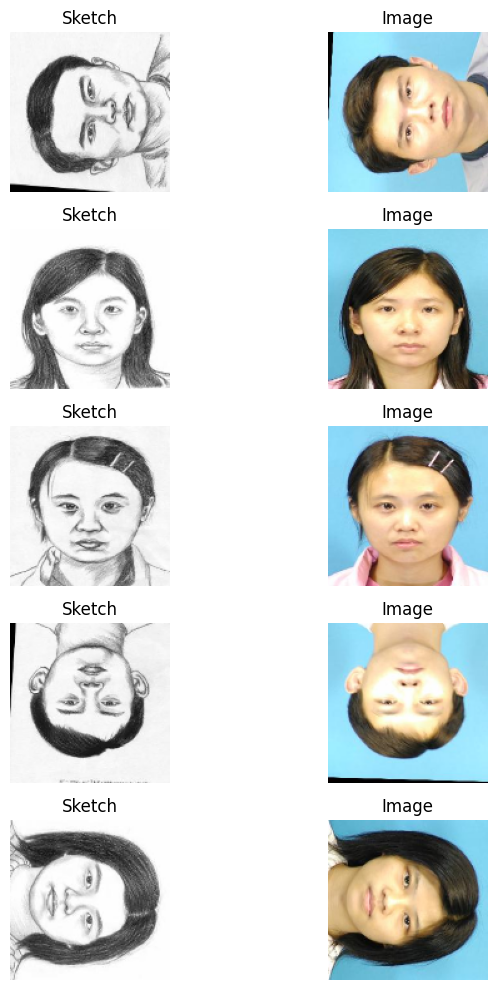

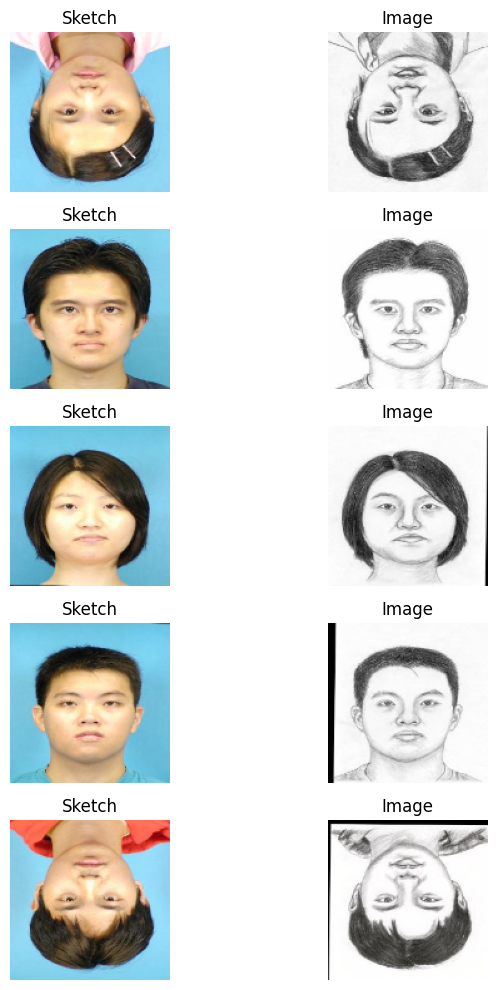

Train dataset size: 1203
Test dataset size: 301


In [50]:
def imshow(img):
    # Unnormalize the image
    img = img * 255.0  # Multiply by 255 to revert to [0, 255] range
    img = img.clamp(0, 255)  # Clamp values to be within [0, 255]
    npimg = img.numpy().astype(np.uint8)  # Convert to uint8
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
sketches, images = next(dataiter)

# Display a few sketches and their corresponding images
num_images = 5  # Number of images to display
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i in range(num_images):
    sketch = sketches[i]
    image = images[i]

    # Unnormalize and convert tensors to images
    sketch_img = sketch * 255.0
    sketch_img = sketch_img.clamp(0, 255).byte()
    sketch_img = transforms.ToPILImage()(sketch_img)

    image_img = image * 255.0
    image_img = image_img.clamp(0, 255).byte()
    image_img = transforms.ToPILImage()(image_img)

    # Display the sketch
    axes[i, 0].imshow(sketch_img)
    axes[i, 0].set_title('Sketch')
    axes[i, 0].axis('off')

    # Display the corresponding image
    axes[i, 1].imshow(image_img)
    axes[i, 1].set_title('Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Repeat for the test loader
dataiter = iter(test_loader)
sketches, images = next(dataiter)

# Display a few sketches and their corresponding images from the test set
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i in range(num_images):
    sketch = sketches[i]
    image = images[i]

    # Unnormalize and convert tensors to images
    sketch_img = sketch * 255.0
    sketch_img = sketch_img.clamp(0, 255).byte()
    sketch_img = transforms.ToPILImage()(sketch_img)

    image_img = image * 255.0
    image_img = image_img.clamp(0, 255).byte()
    image_img = transforms.ToPILImage()(image_img)

    # Display the image
    axes[i, 0].imshow(sketch_img)
    axes[i, 0].set_title('Sketch')
    axes[i, 0].axis('off')

    # Display the corresponding sketch
    axes[i, 1].imshow(image_img)
    axes[i, 1].set_title('Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

In [9]:
def get_image_dimensions(data_loader):
    for batch, _ in data_loader:
        return batch.shape[1:]  # Returns (channels, height, width)

In [55]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


class Encoder(nn.Module):
    def __init__(self, conv_dim , z_dim):
        super(Encoder, self).__init__()
        self.conv1 = conv(3, conv_dim, 4)        # 64x64
        self.conv2 = conv(conv_dim, conv_dim*2, 4)  # 32x32
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)  # 16x16
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)  # 8x8
        self.conv5 = conv(conv_dim*8, conv_dim*8, 4)  # 4x4
        self.fc_mu = nn.Linear(conv_dim*8 * 4 * 4, z_dim)
        self.fc_logvar = nn.Linear(conv_dim*8 * 4 * 4, z_dim)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = out.view(out.size(0), -1)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, conv_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(z_dim, conv_dim*8 * 4 * 4)
        self.deconv1 = deconv(conv_dim*8, conv_dim*8, 4)
        self.deconv2 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv3 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv4 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv5 = deconv(conv_dim, conv_dim, 4, batch_norm=True)

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), -1, 4, 4)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        out = F.relu(self.deconv4(out))
        out = F.tanh(self.deconv5(out))
        return out

# class Encoder(nn.Module):
#     def __init__(self, conv_dim=64, z_dim=100):
#         super(Encoder, self).__init__()

#         def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
#             layers = []
#             conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
#                                    kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
#             layers.append(conv_layer)
#             if batch_norm:
#                 layers.append(nn.BatchNorm2d(out_channels))
#             return nn.Sequential(*layers)

#         self.conv1 = conv(3, conv_dim, 4, batch_norm=False)  # 64x64
#         self.conv2 = conv(conv_dim, conv_dim*2, 4)          # 32x32
#         self.conv3 = conv(conv_dim*2, conv_dim*4, 4)        # 16x16
#         self.conv4 = conv(conv_dim*4, conv_dim*8, 4)        # 8x8
#         self.conv5 = conv(conv_dim*8, conv_dim*8, 4)        # 4x4

#         self.fc_mu = nn.Linear(conv_dim*8 * 4 * 4, z_dim)
#         self.fc_logvar = nn.Linear(conv_dim*8 * 4 * 4, z_dim)

#     def forward(self, x):
#         out = F.leaky_relu(self.conv1(x), 0.2)
#         out = F.leaky_relu(self.conv2(out), 0.2)
#         out = F.leaky_relu(self.conv3(out), 0.2)
#         out = F.leaky_relu(self.conv4(out), 0.2)
#         out = F.leaky_relu(self.conv5(out), 0.2)

#         out = out.view(out.size(0), -1)
#         mu = self.fc_mu(out)
#         logvar = self.fc_logvar(out)

#         return mu, logvar


class SharpeningLayer(nn.Module):
    def __init__(self):
        super(SharpeningLayer, self).__init__()
        self.weight = nn.Parameter(torch.tensor([[0, -1, 0],
                                                 [-1, 5, -1],
                                                 [0, -1, 0]]).unsqueeze(0).unsqueeze(0).float())
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return F.conv2d(x, self.weight.repeat(x.size(1), 1, 1, 1), self.bias, padding=1, groups=x.size(1))

class Generator(nn.Module):
    def __init__(self, z_dim , conv_dim):
        super(Generator, self).__init__()
        # Linear layer to project z_dim into the initial feature map size
        self.fc = nn.Linear(z_dim, conv_dim*8 * 4 * 4)
        # Deconvolution layers to upsample the feature maps
        self.deconv1 = deconv(conv_dim*8, conv_dim*8, 4)  # 8x8
        self.deconv2 = deconv(conv_dim*8, conv_dim*4, 4)  # 16x16
        self.deconv3 = deconv(conv_dim*4, conv_dim*2, 4)  # 32x32
        self.deconv4 = deconv(conv_dim*2, conv_dim, 4)    # 64x64
        # Final deconvolution layer to produce the output image
        self.deconv5 = deconv(conv_dim, 3, 4, batch_norm=True)  # 128x128

    def forward(self, z):
        # Linear layer followed by reshaping to start the deconvolution process
        out = self.fc(z)
        out = out.view(out.size(0), -1, 4, 4)
        # Pass through the deconvolution layers
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        out = F.relu(self.deconv4(out))
        out = F.tanh(self.deconv5(out))  # Final output image
        return out

class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=True)  # 64x64
        self.conv2 = conv(conv_dim, conv_dim*2, 4)           # 32x32
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)         # 16x16
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)         # 8x8
        self.conv5 = conv(conv_dim*8, conv_dim*8, 4)         # 4x4
        self.conv6 = conv(conv_dim*8, 1, 4, stride=1, padding=0, batch_norm=True)  # 1x1

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.conv6(out)
        return out.view(-1, 1)

# class PerceptualLoss(nn.Module):
#     def __init__(self):
#         super(PerceptualLoss, self).__init__()
#         vgg = models.vgg16(pretrained=True).features
#         self.slice1 = nn.Sequential()
#         self.slice2 = nn.Sequential()
#         self.slice3 = nn.Sequential()
#         self.slice4 = nn.Sequential()
#         for x in range(4):
#             self.slice1.add_module(str(x), vgg[x])
#         for x in range(4, 9):
#             self.slice2.add_module(str(x), vgg[x])
#         for x in range(9, 16):
#             self.slice3.add_module(str(x), vgg[x])
#         for x in range(16, 23):
#             self.slice4.add_module(str(x), vgg[x])
#         for param in self.parameters():
#             param.requires_grad = False

#     def forward(self, x, y):
#         h_x = x
#         h_y = y
#         h1_x = self.slice1(h_x)
#         h1_y = self.slice1(h_y)
#         h2_x = self.slice2(h1_x)
#         h2_y = self.slice2(h1_y)
#         h3_x = self.slice3(h2_x)
#         h3_y = self.slice3(h2_y)
#         h4_x = self.slice4(h3_x)
#         h4_y = self.slice4(h3_y)
#         return F.mse_loss(h1_x, h1_y) + F.mse_loss(h2_x, h2_y) + F.mse_loss(h3_x, h3_y) + F.mse_loss(h4_x, h4_y)


class VAE_GAN(nn.Module):
    def __init__(self, z_dim, conv_dim):
        """
        Initialize the VAE-GAN model with an encoder, decoder, generator, and discriminator.

        Args:
            z_dim (int): Dimensionality of the latent space.
            conv_dim (int): Number of channels in the convolution layers.
        """
        super(VAE_GAN, self).__init__()
        self.latent_dim = z_dim
        self.encoder = Encoder(conv_dim, z_dim)
        self.decoder = Decoder(z_dim, conv_dim)
        self.generator = Generator(z_dim, conv_dim)
        self.discriminator = Discriminator(conv_dim)

    def reparameterize(self, mu, logvar):
        """
        Reparameterize using the mean and log-variance to sample from the latent space.

        Args:
            mu (Tensor): Mean of the latent distribution.
            logvar (Tensor): Log-variance of the latent distribution.

        Returns:
            Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)  # Ensure std is positive
        eps = torch.randn_like(std)    # Generate random noise
        return mu + eps * std

    def forward(self, x):
        """
        Forward pass through the VAE-GAN model.

        Args:
            x (Tensor): Input tensor (images).

        Returns:
            Tuple[Tensor, Tensor, Tensor]: Reconstructed image, mean, and log-variance from the encoder.
        """
        mu, logvar = self.encoder(x)  # Get latent distribution parameters
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        x_decoded = self.decoder(z)  # Decode latent vector to reconstructed image
        x_recon = self.generator(x_decoded)  # Generate image from reconstructed image
        return x_recon, mu, logvar

In [52]:
def generate_sketches(model, test_loader, device, num_images=16):
    model.eval()
    generated_images = []
    original_images = []

    with torch.no_grad():
        for i, (test_images, _) in enumerate(test_loader):
            if i * test_loader.batch_size >= num_images:
                break

            test_images = test_images.to(device)

            # Generate sketches
            x_recon, _, _ = model(test_images)

            generated_images.extend(x_recon.cpu())
            original_images.extend(test_images.cpu())

            if len(generated_images) >= num_images:
                break

    # Display images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    for idx in range(num_images):
        orig_img = original_images[idx].permute(1, 2, 0).numpy()
        gen_img = generated_images[idx].permute(1, 2, 0).numpy()

        # Rescale images from [0, 1] to [0, 255]
        orig_img = orig_img * 255
        gen_img = gen_img * 255

        # Clip the values to be between 0 and 255
        orig_img = np.clip(orig_img, 0, 255).astype(np.uint8)
        gen_img = np.clip(gen_img, 0, 255).astype(np.uint8)

        axes[idx, 0].imshow(orig_img)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(gen_img)
        axes[idx, 1].set_title("Generated Sketch")
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [53]:
def train_vae_gan(model, train_loader, test_loader, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer_E = optim.Adam(model.encoder.parameters(), lr=0.00001)
    optimizer_D = optim.Adam(model.decoder.parameters(), lr=learning_rate)
    optimizer_G = optim.Adam(model.generator.parameters(), lr=learning_rate)
    optimizer_Disc = optim.Adam(model.discriminator.parameters(), lr=learning_rate)

    adversarial_loss = nn.BCELoss()

    vae_weight = 0.85  # Adjust as needed
    gan_weight = 1.0  # Adjust as needed

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (real_imgs, _) in enumerate(train_loader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Sample random latent codes from the prior distribution
            zp = torch.randn(batch_size, model.latent_dim).to(device)

            # 1. Encoder generates latent codes
            mu, logvar = model.encoder(real_imgs)
            z = model.reparameterize(mu, logvar)

            # 2. Decoder decodes latent codes
            decoded = model.decoder(z)

            # 3. Generator generates images from decoded latent space
            recon_imgs = model.generator(decoded)
            fake_imgs = model.generator(model.decoder(zp))

            # 4. Train Discriminator
            optimizer_Disc.zero_grad()

            # Real images
            d_real = model.discriminator(real_imgs)
            real_loss = adversarial_loss(d_real, torch.ones_like(d_real))

            # Reconstructed images
            d_recon = model.discriminator(recon_imgs.detach())
            fake_recon_loss = adversarial_loss(d_recon, torch.zeros_like(d_recon))

            # Generated images
            d_fake = model.discriminator(fake_imgs.detach())
            fake_gen_loss = adversarial_loss(d_fake, torch.zeros_like(d_fake))

            d_loss = (real_loss + fake_recon_loss + fake_gen_loss) / 3
            d_loss.backward()
            optimizer_Disc.step()

            # 5. Train Generator, Decoder, and Encoder
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()
            optimizer_E.zero_grad()

            # Discriminator's judgement on reconstructed images
            d_recon = model.discriminator(recon_imgs)
            g_recon_loss = adversarial_loss(d_recon, torch.ones_like(d_recon))

            # Discriminator's judgement on generated images
            d_fake = model.discriminator(fake_imgs)
            g_fake_loss = adversarial_loss(d_fake, torch.ones_like(d_fake))

            # Total Generator Loss
            g_loss = g_recon_loss + g_fake_loss

            # VAE Loss
            vae_l = vae_loss(recon_imgs, real_imgs, mu, logvar)

            # Total Loss
            total_loss = vae_weight * vae_l + gan_weight * g_loss
            total_loss.backward()

            optimizer_G.step()
            optimizer_D.step()
            optimizer_E.step()

            train_loss += total_loss.item()

        avg_loss = train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Save sample reconstructed images
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                sample = next(iter(test_loader))[0].to(device)
                mu, logvar = model.encoder(sample)
                z = model.reparameterize(mu, logvar)
                decoded = model.decoder(z)
                recon_imgs = model.generator(decoded)
                img_grid = torch.cat([sample, recon_imgs], dim=0)
                save_image(img_grid, f"reconstruction_epoch_{epoch+1}.png", nrow=batch_size, normalize=True, range=(-1, 1))

    # After training, generate sketches for test images
    generate_sketches(model, test_loader, device)

In [54]:
# Set up the model
z_dim = 50
conv_dim = 64
model = VAE_GAN(z_dim=z_dim, conv_dim=conv_dim)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up the learning rate
learning_rate = 0.0001  # Adjusted learning rate

# Set the number of epochs
num_epochs = 50 # You can adjust this as needed

# Start training
train_vae_gan(model, train_loader, test_loader, num_epochs, learning_rate, device)

# After training, generate sketches
#generate_sketches(model, test_loader, device)

AttributeError: 'VAE_GAN' object has no attribute 'decoder'